In [1]:
import numpy as np 
import pandas as pd 
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import minimize
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [2]:
df = pd.read_csv('/content/covid_impact_on_airport_traffic.csv')
df

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
...,...,...,...,...,...,...,...,...,...,...,...
7242,Daily,2020-06-05,1.0,Seattle-Tacoma International,80,POINT(-122.308661576118 47.4505828917119),SeaTac,Washington,US-WA,United States of America (the),"POLYGON((-122.297594547272 47.434474106872, -1..."
7243,Daily,2020-10-03,1.0,Seattle-Tacoma International,55,POINT(-122.308661576118 47.4505828917119),SeaTac,Washington,US-WA,United States of America (the),"POLYGON((-122.297594547272 47.434474106872, -1..."
7244,Daily,2020-07-16,1.0,Seattle-Tacoma International,76,POINT(-122.308661576118 47.4505828917119),SeaTac,Washington,US-WA,United States of America (the),"POLYGON((-122.297594547272 47.434474106872, -1..."
7245,Daily,2020-07-31,1.0,Seattle-Tacoma International,69,POINT(-122.308661576118 47.4505828917119),SeaTac,Washington,US-WA,United States of America (the),"POLYGON((-122.297594547272 47.434474106872, -1..."


In [3]:
df.Country.value_counts()

United States of America (the)    4441
Canada                            2311
Australia                          257
Chile                              238
Name: Country, dtype: int64

In [4]:
df['Country'] = np.where((df.Country == 'United States of America (the)'), 'USA', df.Country)
df['Country'] = np.where((df.Country == 'Canada'), 'CAN', df.Country)
df['Country'] = np.where((df.Country == 'Australia'), 'AUS', df.Country)
df['Country'] = np.where((df.Country == 'Chile'), 'CHL', df.Country)

In [5]:
df_countrydate = df.groupby(['Date','Country']).mean().reset_index()
df_countrydate

,Date,Country,Version,PercentOfBaseline
0,2020-03-16,AUS,1.0,92.000000
1,2020-03-16,CAN,1.0,92.333333
2,2020-03-16,CHL,1.0,96.000000
3,2020-03-16,USA,1.0,88.058824
4,2020-03-17,AUS,1.0,90.000000
...,...,...,...,...
1014,2020-12-01,USA,1.0,75.000000
1015,2020-12-02,AUS,1.0,27.000000
1016,2020-12-02,CAN,1.0,88.666667
1017,2020-12-02,CHL,1.0,48.000000


In [7]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 144 kB/s 


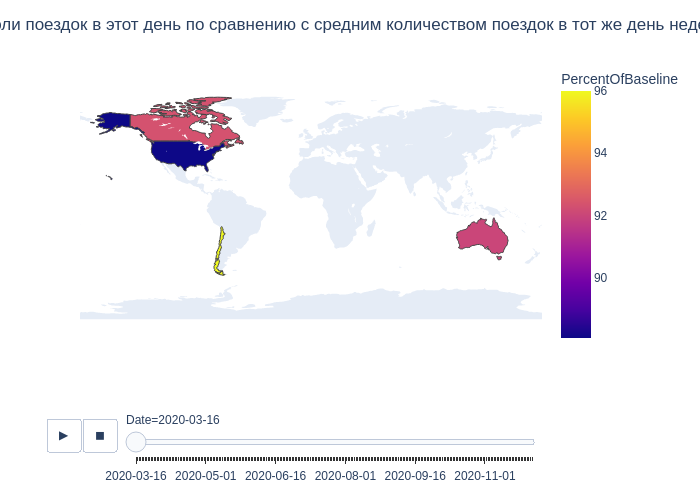

In [6]:
fig = px.choropleth(df_countrydate,  locations="Country", locationmode = "ISO-3", color="PercentOfBaseline", hover_name="Country", animation_frame="Date")
fig.update_layout(title_text = 'Изменение средней доли поездок в этот день по сравнению с средним количеством поездок в тот же день недели в базовом периоде',
                  title_x = 0.5,geo=dict(showframe = False,showcoastlines = False))
    
fig.show('png')

(array([  17.,  174.,  294.,  386.,  646., 1089., 1353., 1105.,  855.,
        1328.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

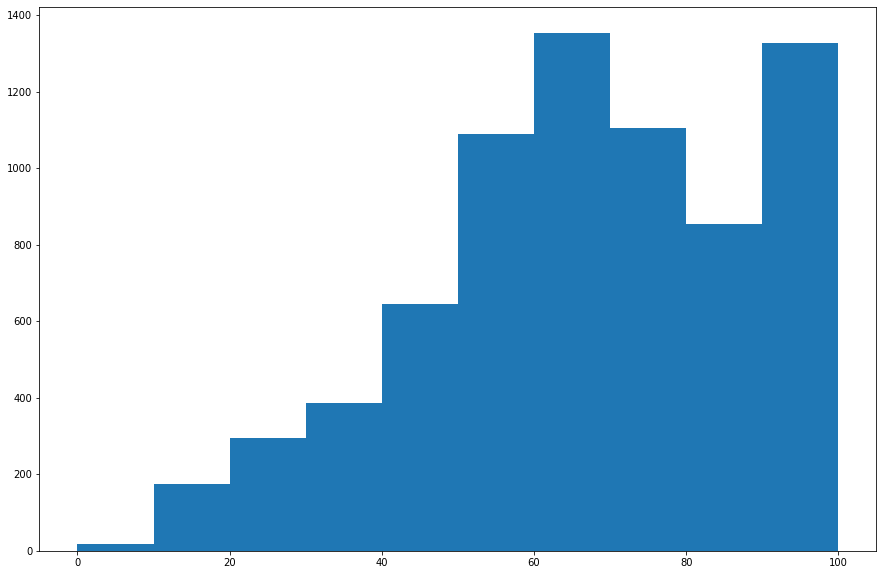

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
ax.hist(df.PercentOfBaseline)


# **Рассмотрим среднюю долю поездок по странам и по городам в каждой из стран.**

In [ ]:
def df_mean_by_countries_or_cities(df, choosen_version = 'country', choosen_country = None):
  if choosen_version == 'country':
    res_df = df.groupby('Country').mean().sort_values('PercentOfBaseline', ascending = False).reset_index()
    return res_df
  if choosen_version == 'city':
    res_df = df.loc[df['Country'] == choosen_country]
    res_df = res_df.groupby('City').mean().sort_values('PercentOfBaseline', ascending = False).reset_index()
    return res_df

In [ ]:
df_mean_by_countries_or_cities(df)

,Country,Version,PercentOfBaseline
0,CAN,1.0,77.409347
1,USA,1.0,64.460932
2,AUS,1.0,37.750973
3,CHL,1.0,34.273109


In [ ]:
df_mean_by_countries_or_cities(df, choosen_version = 'city', choosen_country = 'AUS')

,City,Version,PercentOfBaseline
0,Sydney,1.0,37.750973


In [ ]:
df_mean_by_countries_or_cities(df, choosen_version = 'city', choosen_country = 'CHL')

,City,Version,PercentOfBaseline
0,Santiago,1.0,34.273109


In [ ]:
Canada = df_mean_by_countries_or_cities(df, choosen_version = 'city', choosen_country = 'CAN')
Canada 

,City,Version,PercentOfBaseline
0,Hamilton,1.0,90.426923
1,Winnipeg,1.0,90.157088
2,Calgary,1.0,89.513410
3,Mirabel,1.0,87.338521
4,Richmond,1.0,76.885057
5,Leduc County,1.0,74.305085
6,Dorval,1.0,73.297710
7,Halifax,1.0,57.154762
8,Mississauga,1.0,56.827586


<BarContainer object of 9 artists>

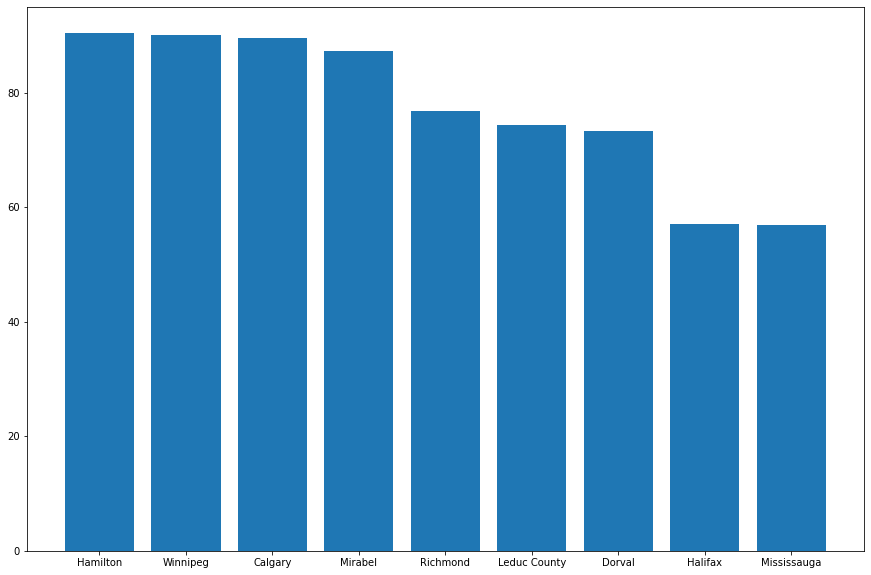

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
ax.bar(x = Canada.City, height = Canada.PercentOfBaseline)

In [ ]:
USA = df_mean_by_countries_or_cities(df, choosen_version = 'city', choosen_country = 'USA')
USA

,City,Version,PercentOfBaseline
0,Newark,1.0,87.413793
1,Urban Honolulu,1.0,84.628352
2,Charlotte,1.0,75.375479
3,Grapevine,1.0,75.293893
4,Chicago,1.0,73.084291
5,Miami Springs,1.0,70.482759
6,Los Angeles,1.0,70.240458
7,Boston,1.0,64.704981
8,SeaTac,1.0,63.980843
9,New York,1.0,61.975143


<BarContainer object of 16 artists>

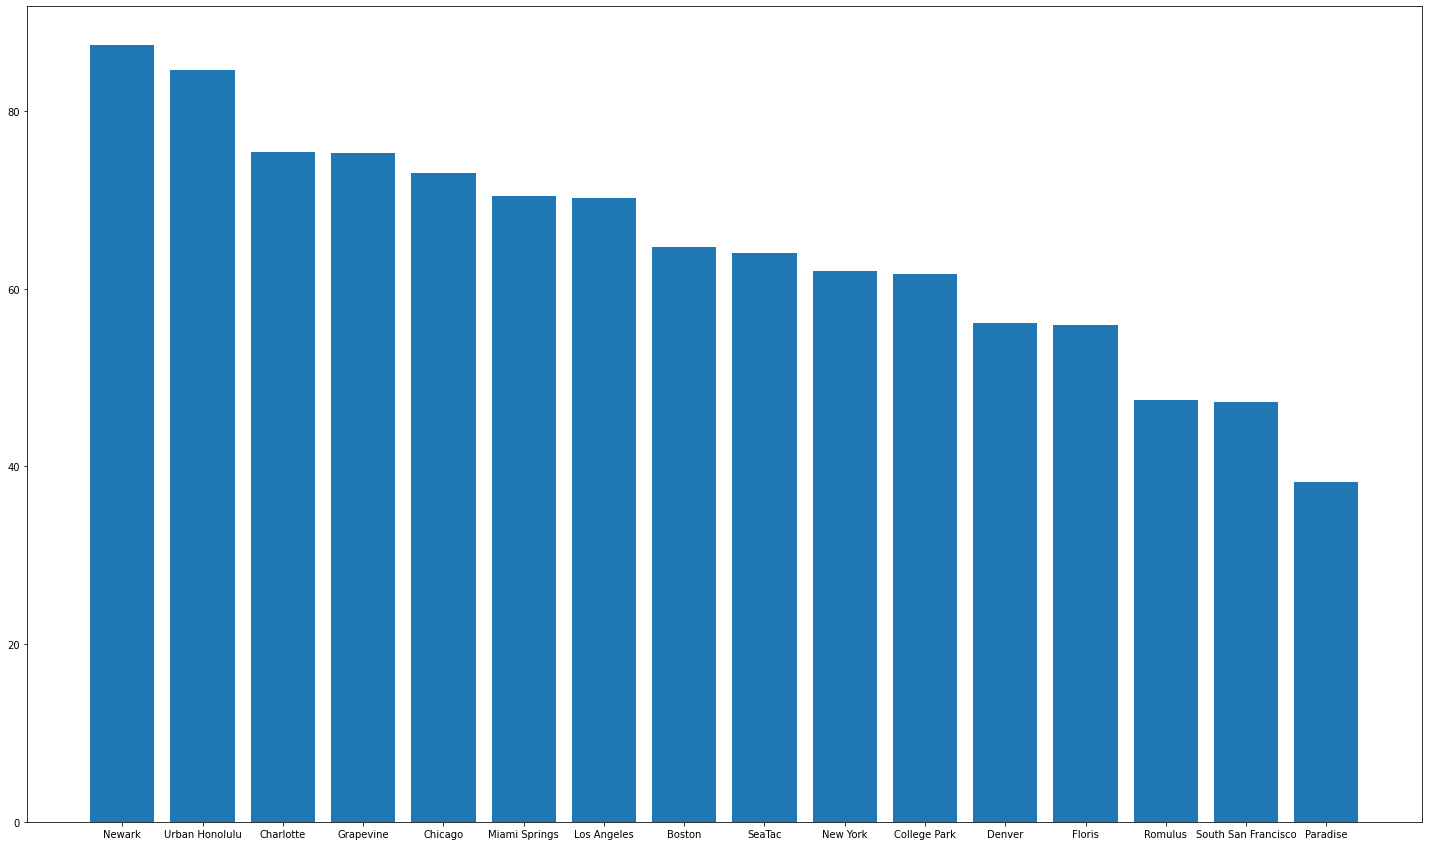

In [ ]:
fig, ax = plt.subplots(figsize = (25,15))
ax.bar(x = USA.City, height = USA.PercentOfBaseline)

**Видим, что различие среднего количества рейсов от нормального времени по городам сильно различается, что говорит о том, что ситуация с коронавирусом и ограничениями в разных регионах влияет на количество рейсов, что можно сравнить по ковидной статистике подробнее.**

# **Проведем проверку гипотез на равенство средних отклонений от нормального состояния для пар USA/Canada и Australia/Chile**

In [ ]:
df_mean_by_countries_or_cities(df)

,Country,Version,PercentOfBaseline
0,CAN,1.0,77.409347
1,USA,1.0,64.460932
2,AUS,1.0,37.750973
3,CHL,1.0,34.273109


## **Australia/Chile**

Text(0.5, 1.0, 'Percent Of Baseline for Chile')

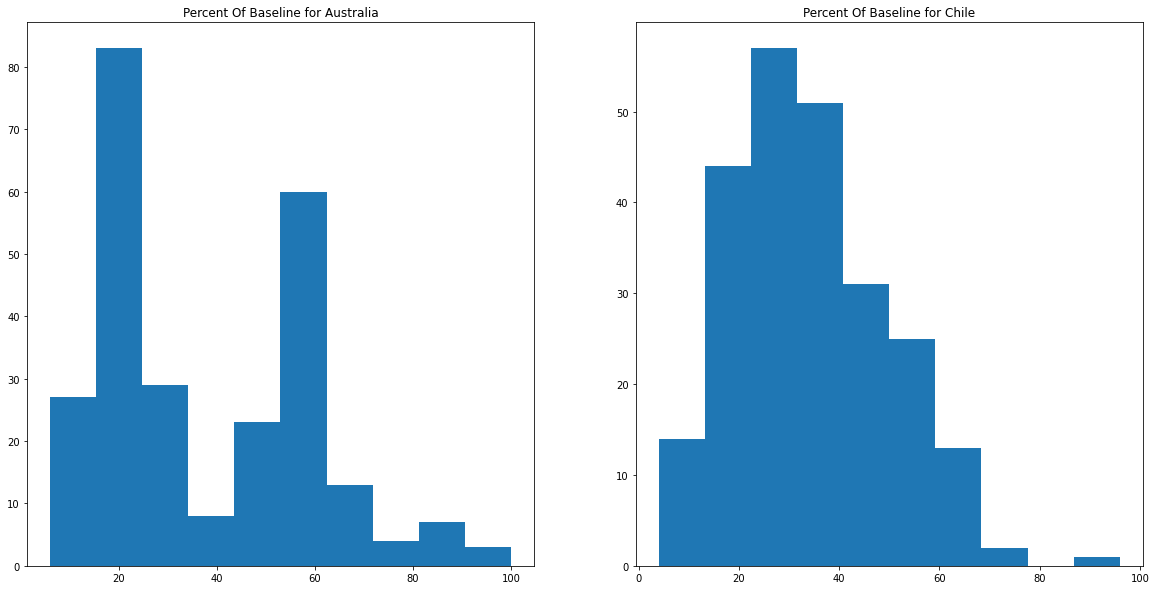

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20,10))
ax[0].hist(df.loc[df['Country'] == 'AUS'].PercentOfBaseline)
ax[0].set_title('Percent Of Baseline for Australia')
ax[1].hist(df.loc[df['Country'] == 'CHL'].PercentOfBaseline)
ax[1].set_title('Percent Of Baseline for Chile')

In [ ]:
print(df.loc[df['Country'] == 'AUS'].PercentOfBaseline.describe(),'\n','\n',df.loc[df['Country'] == 'CHL'].PercentOfBaseline.describe())

count    257.000000
mean      37.750973
std       21.799160
min        6.000000
25%       19.000000
50%       27.000000
75%       56.000000
max      100.000000
Name: PercentOfBaseline, dtype: float64 
 
 count    238.000000
mean      34.273109
std       14.906353
min        4.000000
25%       23.250000
50%       32.000000
75%       45.000000
max       96.000000
Name: PercentOfBaseline, dtype: float64


**Будем использовать критерий Уилкоксона для проверки гипотезы о равенстве средних, так как распределения среднего количетсва рейсов от нормального времени имеет негауссовское распределение, а также выборки могут быть зависимы, так как существуют прямые рейсы между странами.**

In [ ]:
australia_cr = df.loc[df['Country'] == 'AUS'].PercentOfBaseline[0:238]
chile_cr = df.loc[df['Country'] == 'CHL'].PercentOfBaseline

stat, p = wilcoxon(australia_cr, chile_cr)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=11863.500, p=0.107
Same distribution (fail to reject H0)


**Видим, что критерий Уилкоксона говорит, что данные взяты из одного распределения с одинаковыми средними соотвественно.**

## **USA/Canada** 

Text(0.5, 1.0, 'Percent Of Baseline for Canada')

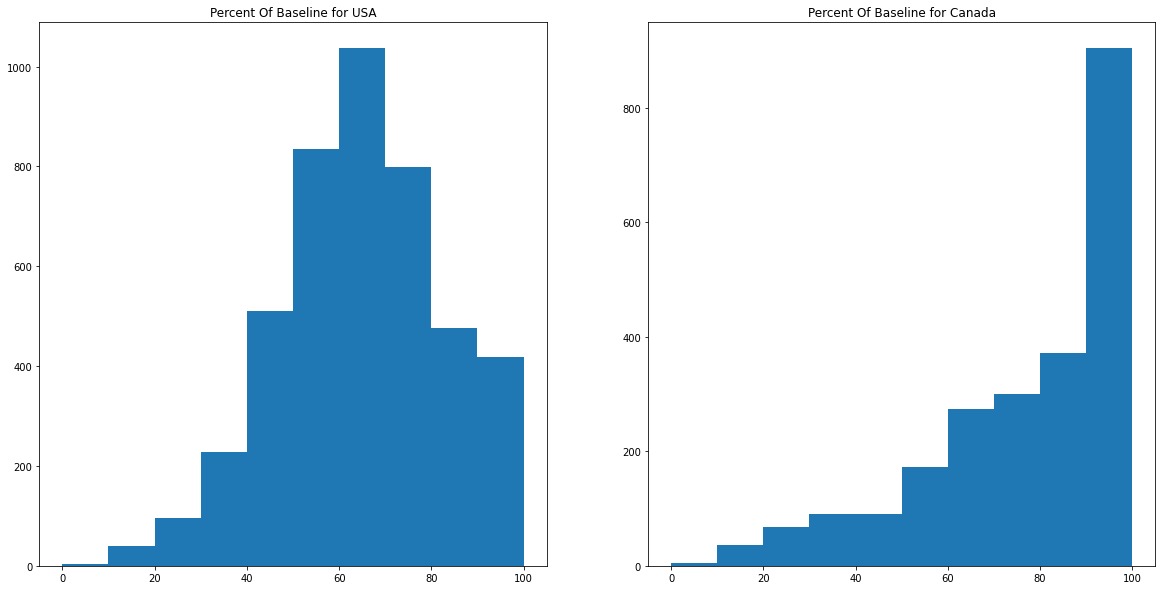

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20,10))
ax[0].hist(df.loc[df['Country'] == 'USA'].PercentOfBaseline)
ax[0].set_title('Percent Of Baseline for USA')
ax[1].hist(df.loc[df['Country'] == 'CAN'].PercentOfBaseline)
ax[1].set_title('Percent Of Baseline for Canada')

In [ ]:
print(df.loc[df['Country'] == 'USA'].PercentOfBaseline.describe(),'\n','\n',df.loc[df['Country'] == 'CAN'].PercentOfBaseline.describe())

count    4441.000000
mean       64.460932
std        18.081394
min         0.000000
25%        53.000000
50%        64.000000
75%        77.000000
max       100.000000
Name: PercentOfBaseline, dtype: float64 
 
 count    2311.000000
mean       77.409347
std        22.517052
min         0.000000
25%        64.000000
50%        84.000000
75%        99.000000
max       100.000000
Name: PercentOfBaseline, dtype: float64


**По аналогичным соображениям предыдущего пункта проведем тест Уилкоксона**

In [ ]:
usa_cr = df.loc[df['Country'] == 'USA'].PercentOfBaseline.sample(n=2311, random_state=1)
canada_cr = df.loc[df['Country'] == 'CAN'].PercentOfBaseline

stat, p = wilcoxon(usa_cr , canada_cr)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=643832.000, p=0.000
Different distribution (reject H0)


**Видим, что в этом случае данные происходят из разных распределений, с разными средними соответсвенно. Этому может быть связано с различными ограничениями вводимыми в странах в период ковида.**

# **Работа с временными рядами.**

In [ ]:
df_timeline = df.groupby(['Date']).mean().reset_index()
df_timeline = df_timeline.set_index('Date')

In [ ]:
rolling_mean = df_timeline['PercentOfBaseline'].rolling(window = 7).mean()

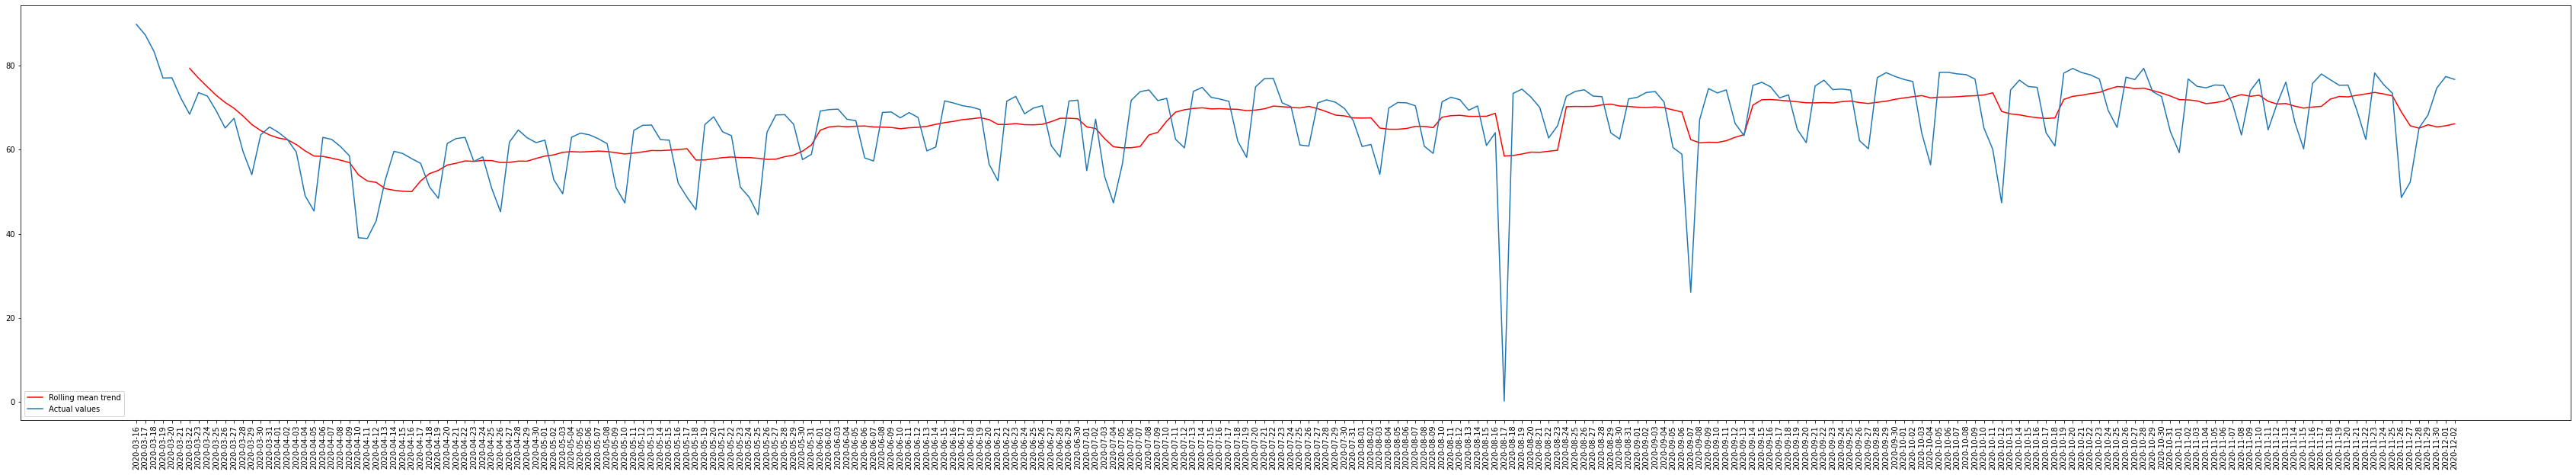

In [ ]:
plt.figure(figsize=(60,10))

plt.plot(rolling_mean, color='red', label="Rolling mean trend")
plt.xticks(rotation=90)
plt.plot(df_timeline['PercentOfBaseline'], label="Actual values")
plt.legend(loc='lower left')

**Видим 2 точки с резким падением среднего процента, рассмотрим их в дальнейшем подробнее в контексте новостей в те дни**

**По новостям не было найдень конкретных решений или законов принятых 2020-08-17, однако при этом такая статистика была в США:** 

**Всего скончались 170 019 пациентов. Кроме того, с начала пандемии в США коронавирусом заразились 5 401 167 человек. Во всем мире насчитывается 21 590 578 случаев COVID-19, умерли более 773 тыс. человек.**

## **Простое экспоненциальное сглаживание**

Text(0.5, 1.0, 'Simple Exponential Smoothing')

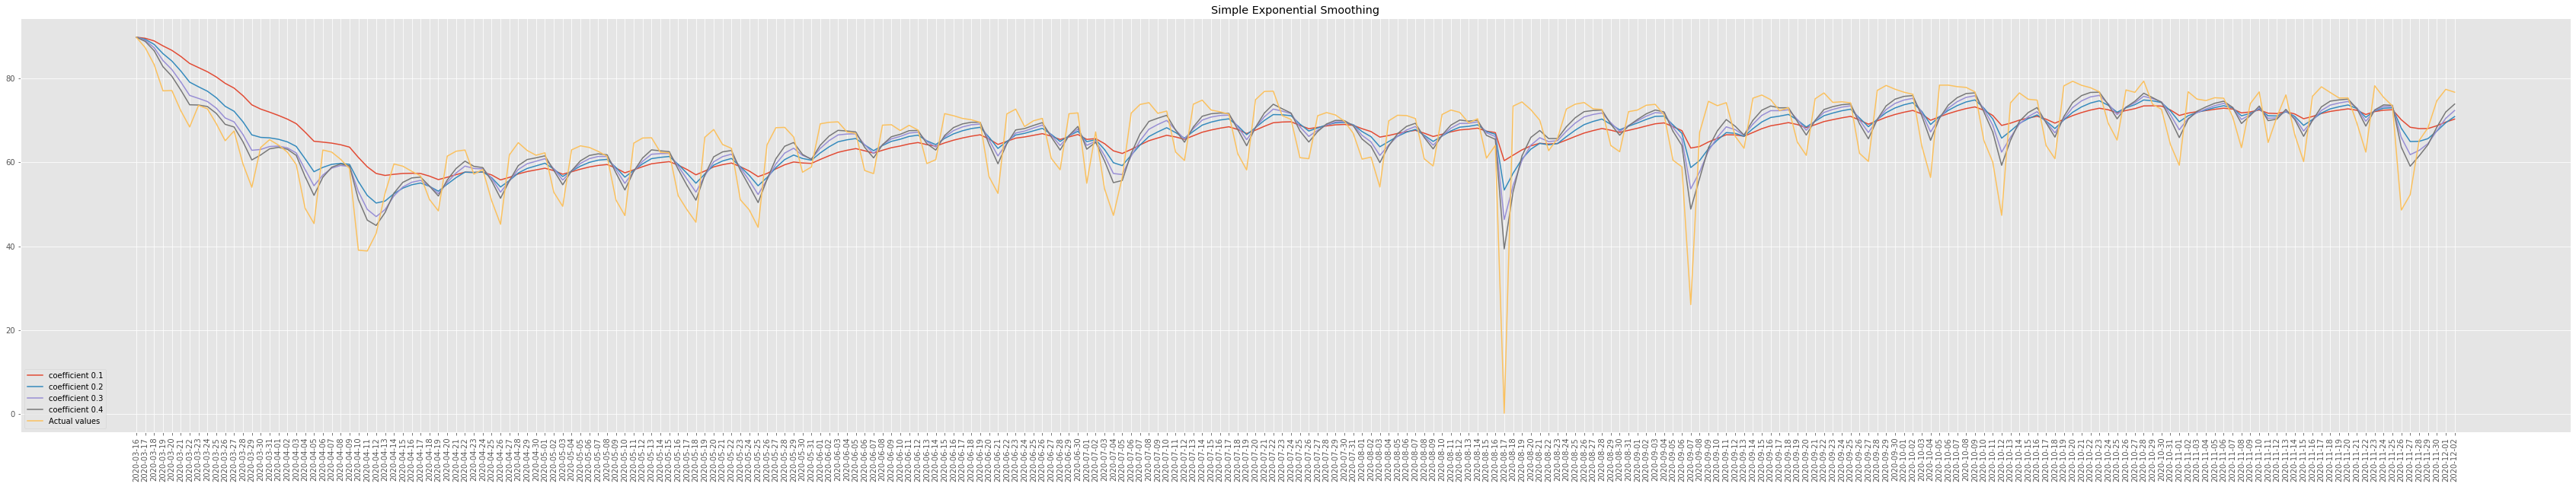

In [ ]:
def simple_exponential_smoothing(series, coefficient):
  result = [series[0]] # first value is same as series
  for i in range(1, len(series)):
      result.append(coefficient * series[i] + (1 - coefficient) * result[i-1])
  return result

plt.style.use("ggplot")

plt.figure(figsize=(60,10))
for coefficient in [0.1,0.2,0.3,0.4]:
  plt.plot(simple_exponential_smoothing(df_timeline['PercentOfBaseline'], coefficient), label=f"coefficient {coefficient}")
plt.plot(df_timeline['PercentOfBaseline'],label = "Actual values")
plt.legend(loc='lower left')
plt.xticks(rotation=90)
plt.title("Simple Exponential Smoothing")


## **Двойное экспоненциальное сглаживание**

Text(0.5, 1.0, 'Double Exponential Smoothing')

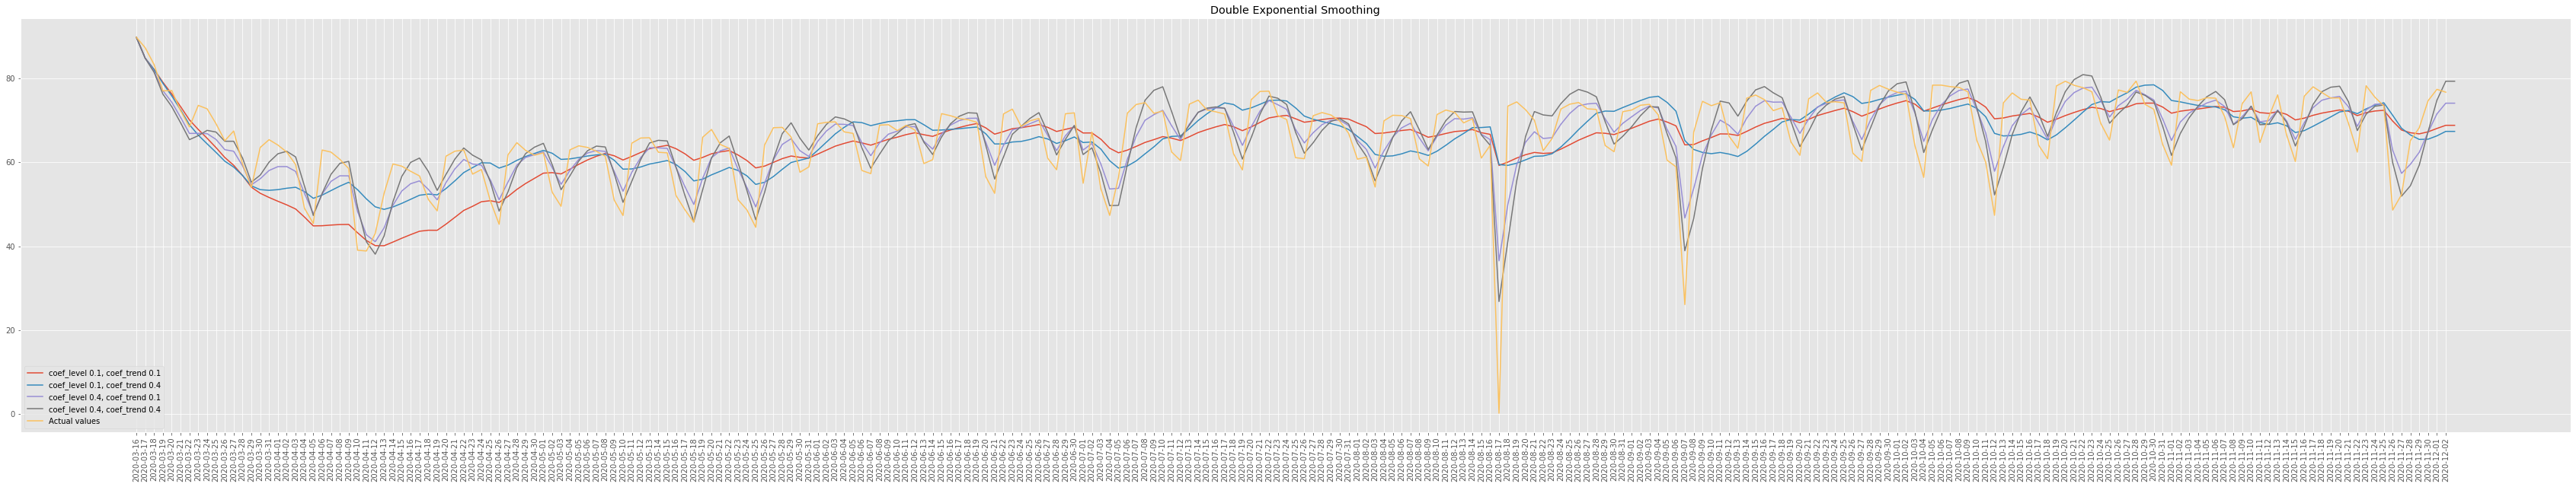

In [ ]:
def double_exponential_smoothing(series, coef_level, coef_trend):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
            last_level, level = level, coef_level*value + (1-coef_level)*(level+trend)
            trend = coef_trend*(level-last_level) + (1-coef_trend)*trend
        result.append(level+trend)
    return result

plt.figure(figsize=(60,10))
for coef_level in [0.1,0.4]:
  for coef_trend in [0.1,0.4]:
    plt.plot(double_exponential_smoothing(df_timeline['PercentOfBaseline'], coef_level, coef_trend), label=f"coef_level {coef_level}, coef_trend {coef_trend}")
plt.plot(df_timeline['PercentOfBaseline'],label = "Actual values")
plt.legend(loc='lower left')
plt.xticks(rotation=90)
plt.title("Double Exponential Smoothing")

## **Подбор оптимальных параметров для двойного экспоненциального сглаживания с помощью градиентного спуска по кросс-валидации на временном ряду**

In [ ]:
def fit_double_exponential_smoothing(series, coef_level, coef_trend):
    result = [series[0]]
    for n in range(1, len(series)):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        else:
            value = series[n]
            last_level, level = level, coef_level*value + (1-coef_level)*(level+trend)
            trend = coef_trend*(level-last_level) + (1-coef_trend)*trend
        result.append(level+trend)
    return coef_level, coef_trend

def predict_double_exponential_smoothing(series, coef_level, coef_trend):
    result = [series[0]]
    for n in range(1, len(series)):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        else:
            value = series[n]
            last_level, level = level, coef_level*value + (1-coef_level)*(level+trend)
            trend = coef_trend*(level-last_level) + (1-coef_trend)*trend
        result.append(level+trend)
    return result 

def series_error_with_CVD(start_coef):
  errors = []

  values = df_timeline['PercentOfBaseline']
  coef_level, coef_trend = start_coef

  tscv = TimeSeriesSplit(n_splits=5)

  for train, test in tscv.split(values):

    prediction_coefs = fit_double_exponential_smoothing(values[train], coef_level, coef_trend)
    
    predictions = predict_double_exponential_smoothing(values[test], prediction_coefs[0], prediction_coefs[1])
    actual = values[test]
    error = mean_squared_error(predictions, actual)
    errors.append(error)

    return np.mean(np.array(errors))

In [ ]:
x = [0, 0]

opt = minimize(series_error_with_CVD, x0=x, method="TNC", bounds = ((0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
coef_level_opt, coef_trend_opt = opt.x
print( coef_level_opt, coef_trend_opt)

0.9601537872703958 0.11873035101654905


Text(0.5, 1.0, 'Double Exponential Smoothing Optimal')

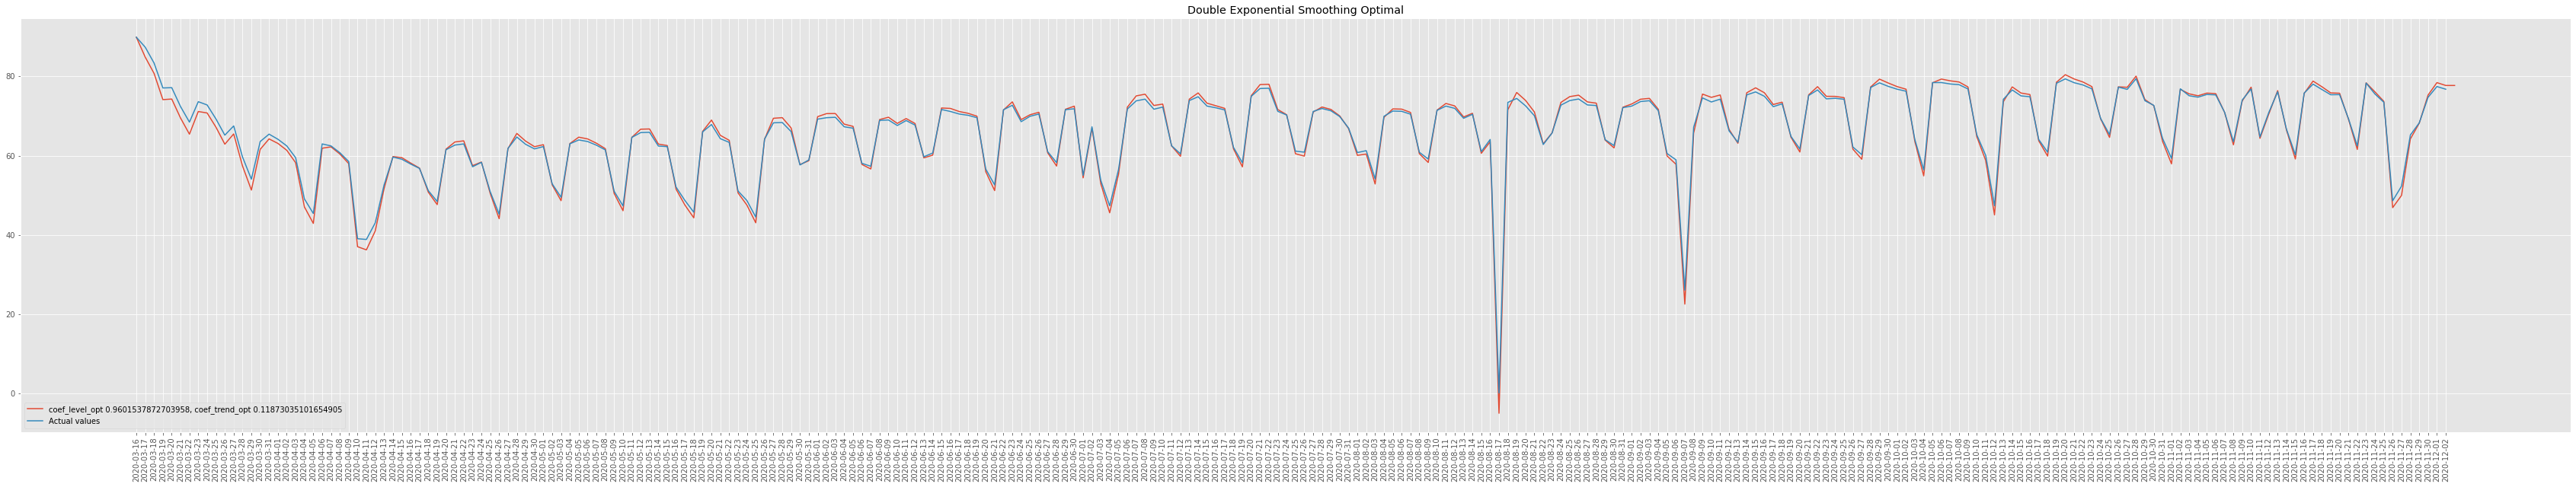

In [ ]:
plt.figure(figsize=(60,10))


plt.plot(double_exponential_smoothing(df_timeline['PercentOfBaseline'], coef_level_opt, coef_trend_opt), label=f"coef_level_opt {coef_level_opt}, coef_trend_opt {coef_trend_opt}")
plt.plot(df_timeline['PercentOfBaseline'],label = "Actual values")
plt.legend(loc='lower left')
plt.xticks(rotation=90)
plt.title("Double Exponential Smoothing Optimal")

## **Градиентный метод оптимизации**

In [ ]:
def values_of_d_e_s(series, coef_level, coef_trend):
    result = [series[0]]
    l_x = []
    b_x = []
    for n in range(1, len(series)):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
            l_x.append(level)
            b_x.append(trend)
        else:
            value = series[n]
            last_level, level = level, coef_level*value + (1-coef_level)*(level+trend)
            trend = coef_trend*(level-last_level) + (1-coef_trend)*trend
            l_x.append(level)
            b_x.append(trend)
        result.append(level+trend)
    return result[1:], l_x, b_x

def double_exponential_smoothing(series, coef_level, coef_trend):
    result = [series[0]]
    for n in range(1, len(series)):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        else:
            value = series[n]
            last_level, level = level, coef_level*value + (1-coef_level)*(level+trend)
            trend = coef_trend*(level-last_level) + (1-coef_trend)*trend
        result.append(level+trend)
    return result

def fit_predict(values_of_d_e_s, coef_level, coef_trend, lr):

  values = df_timeline['PercentOfBaseline']
  tscv = TimeSeriesSplit(n_splits=5)

  for train, test in tscv.split(values):
    grad = [0,0]

    values_for_train = values[train][1:]
    for i in range(1000):
      result, l_x, b_x = values_of_d_e_s(values[train], coef_level, coef_trend)
      values_for_train = values[train][1:]
      for i in range(1,len(values_for_train)):
          grad[0] += (values_for_train[i] - result[i]) * (-values_for_train[i-1] + l_x[i-1] + b_x[i-1])
          grad[1] +=(values_for_train[i] - result[i]) * (-l_x[i] + l_x[i-1] + b_x[i-1])
    
      grad[0] = 2*grad[0] / (len(values_for_train)-1)
      grad[1] = 2*grad[1] / (len(values_for_train)-1)

      if np.sqrt(grad[0]**2 + grad[1]**2) > 1:
        grad[0] = grad[0]/np.sqrt(grad[0]**2 + grad[1]**2)
        grad[1] = grad[1]/np.sqrt(grad[0]**2 + grad[1]**2)
      
      if abs(grad[0]) < 0.00001 and abs(grad[1]) < 0.00001:
        break

      coef_level -= lr*grad[0]
      coef_trend -= lr*grad[1]

    if coef_level > 1:
      coef_level = 1
    if coef_trend > 1:
      coef_trend = 1
    if coef_level < 0:
      coef_level = 0
    if coef_trend < 0:
      coef_trend = 0
    coefs = []
    coefs.append([coef_level, coef_trend])
    errors = []
    predictions = double_exponential_smoothing(values[test], coef_level, coef_level)
    actual = values[test]
    error = mean_squared_error(predictions, actual)
    errors.append(error)
    coef_level, coef_trend = coefs[errors.index(min(errors))][0], coefs[errors.index(min(errors))][1]

  return coef_level, coef_trend


coef_level_grad, coef_trend_grad = fit_predict(values_of_d_e_s, 0.1, 0.1, 0.00003)
print(coef_level_grad, coef_trend_grad)

0.23061513609662795 0.24984847307708033


Text(0.5, 1.0, 'Double Exponential Smoothing Optimal')

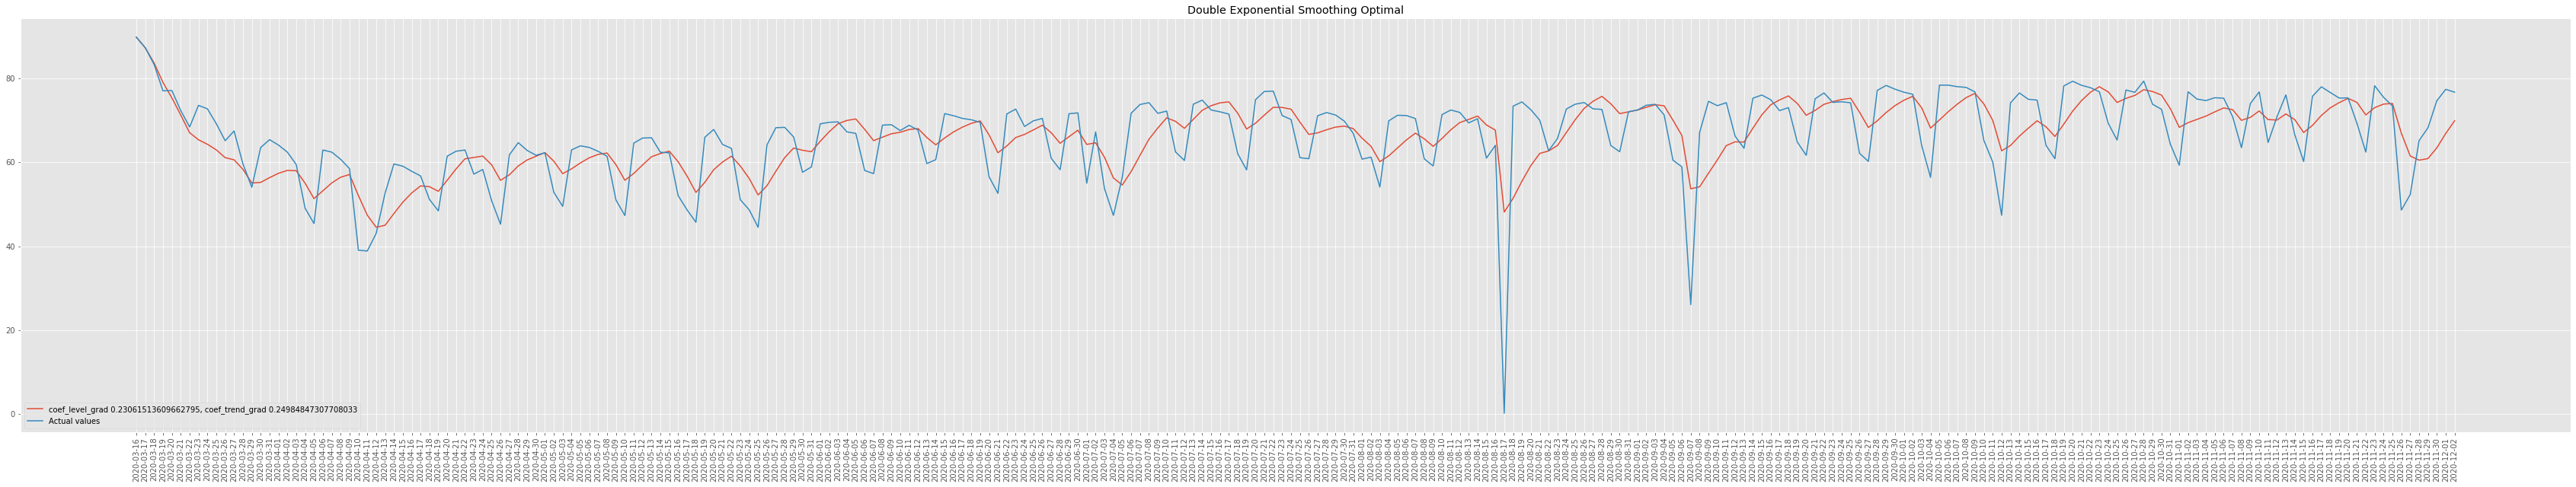

In [ ]:
plt.figure(figsize=(60,10))
plt.plot(double_exponential_smoothing(df_timeline['PercentOfBaseline'], coef_level_grad, coef_trend_grad), label=f"coef_level_grad {coef_level_grad}, coef_trend_grad {coef_trend_grad}")
plt.plot(df_timeline['PercentOfBaseline'],label = "Actual values")

plt.legend(loc='lower left')
plt.xticks(rotation=90)
plt.title("Double Exponential Smoothing Optimal")

**С помощью реализованного "руками" метода градиента можно получить реализацию как из пункта выше, также редактируя learning rate(lr), можно получить усреднение и сглаживание как сейчас.**

In [ ]:
coef_level_grad, coef_trend_grad = fit_predict(values_of_d_e_s, 0.1, 0.1, 0.0003)
print(coef_level_grad, coef_trend_grad)

0.9719311236089442 0.18889425002905078


Text(0.5, 1.0, 'Double Exponential Smoothing Optimal')

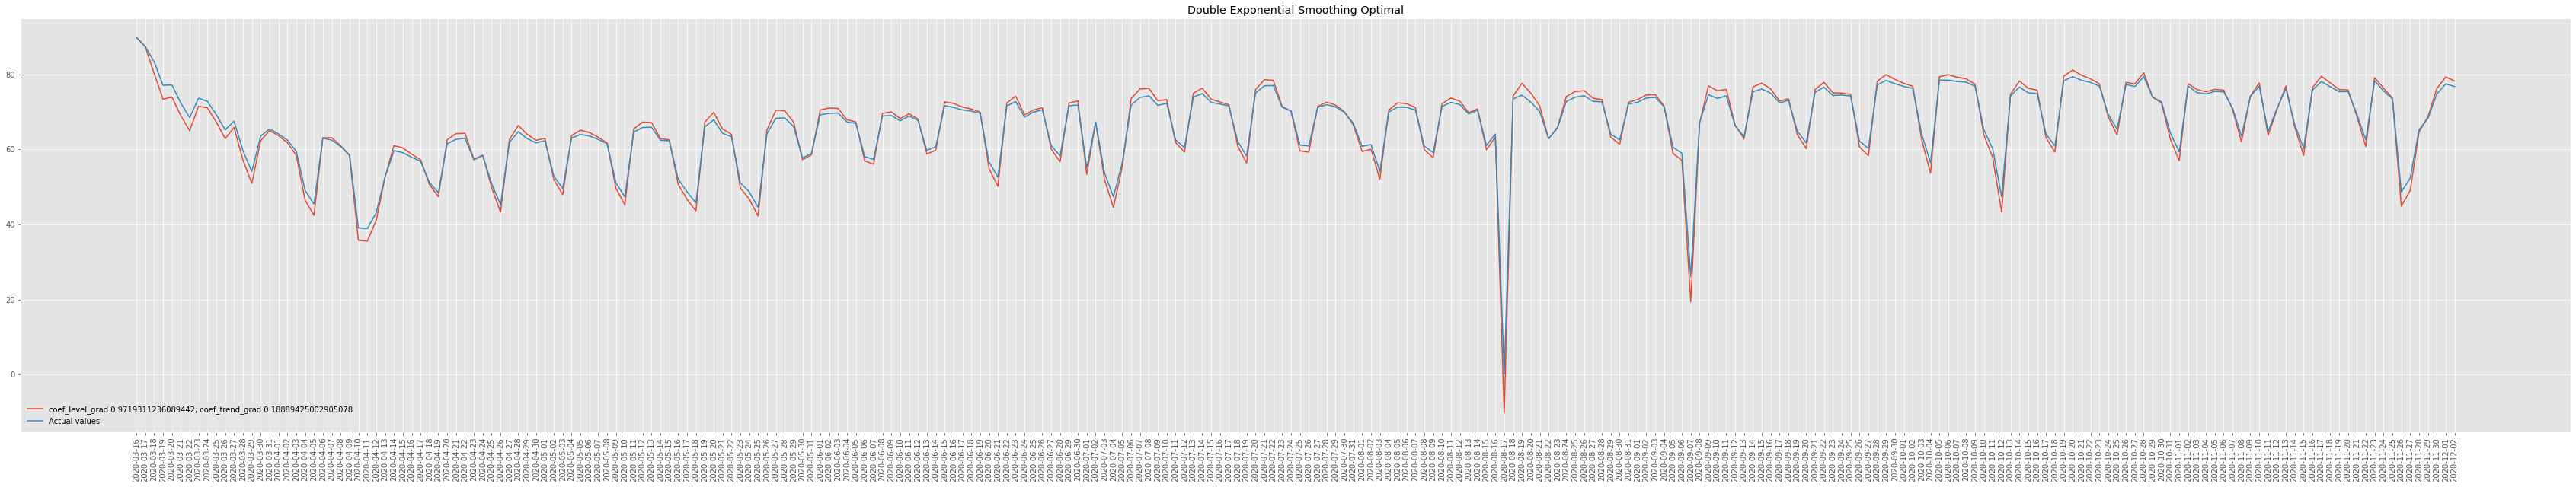

In [ ]:
plt.figure(figsize=(60,10))
plt.plot(double_exponential_smoothing(df_timeline['PercentOfBaseline'], coef_level_grad, coef_trend_grad), label=f"coef_level_grad {coef_level_grad}, coef_trend_grad {coef_trend_grad}")
plt.plot(df_timeline['PercentOfBaseline'],label = "Actual values")

plt.legend(loc='lower left')
plt.xticks(rotation=90)
plt.title("Double Exponential Smoothing Optimal")

**Повторение результата реализации из пункта выше.**

# **Нестационарность и SARIMA**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Критерий Дики-Фуллера: p=0.398661


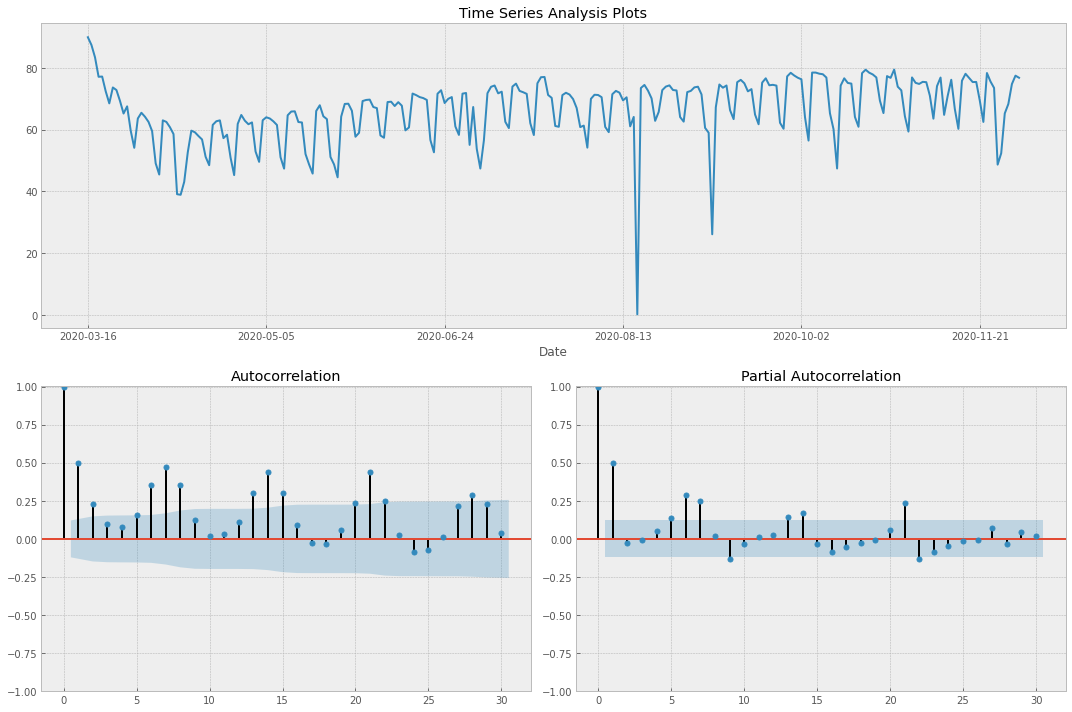

In [ ]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax,method='ywm')

        print("Критерий Дики-Фуллера: p=%f" % adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df_timeline.PercentOfBaseline, lags=30)

**Ожидаемо видим, что ряд не является стационарным, о чем нам говорит тест Дики-Фуллера.**

**Видим, что в данных присутствует недельная сезонность, поэтому сначала делаем разницу и удаляем сезонность**

Критерий Дики-Фуллера: p=0.000043


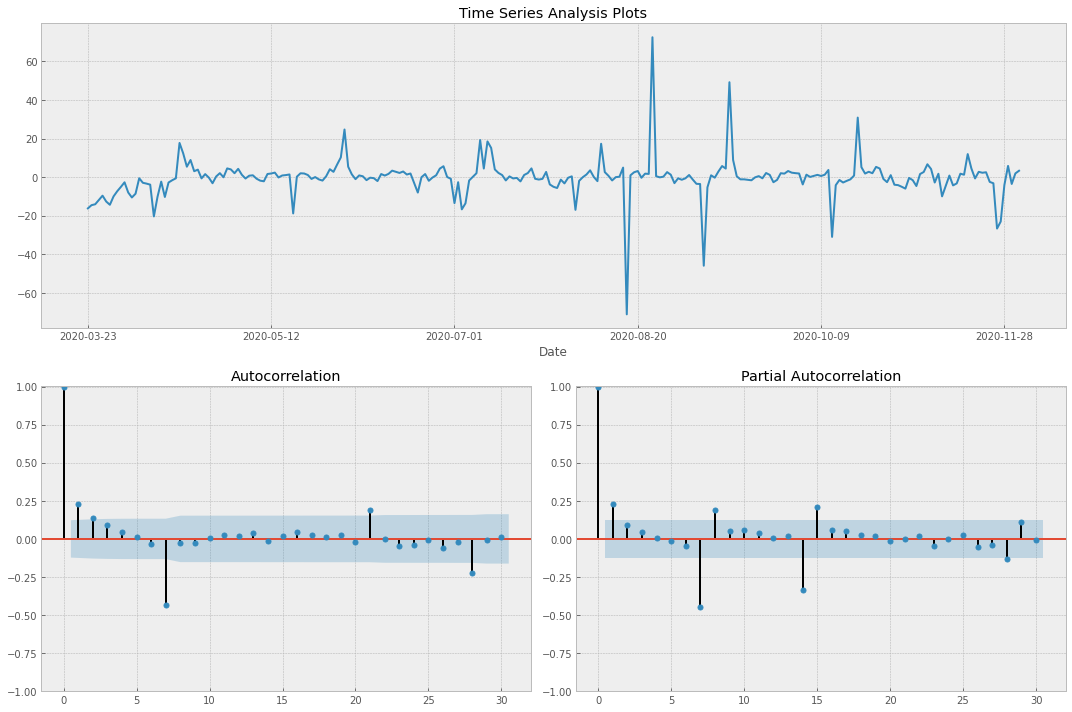

In [ ]:
changed = df_timeline.PercentOfBaseline - df_timeline.PercentOfBaseline.shift(7)
tsplot(changed[7:], lags=30)

**ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA, предположительно значение равно 2, проверим до 5.**

**PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR, предположительно коэффициент 14.**

**Q = 2, P = 2, q = 2, p = 14**

**Далее произведем поиск оптимальных параметров длля модели SARIMA**

In [ ]:
from itertools import product
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

ps = range(7,15,7)
d=1 
qs = range(2, 6)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)  # 32

32

In [ ]:
%%time
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=SARIMAX(df_timeline.PercentOfBaseline, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

wrong parameters: (7, 2, 1, 0)
wrong parameters: (7, 2, 1, 1)
wrong parameters: (7, 3, 1, 0)
wrong parameters: (7, 3, 1, 1)
wrong parameters: (7, 4, 1, 0)
wrong parameters: (7, 4, 1, 1)
wrong parameters: (7, 5, 1, 0)
wrong parameters: (7, 5, 1, 1)
wrong parameters: (14, 2, 1, 0)
wrong parameters: (14, 2, 1, 1)
wrong parameters: (14, 3, 1, 0)
wrong parameters: (14, 3, 1, 1)
wrong parameters: (14, 4, 1, 0)
wrong parameters: (14, 4, 1, 1)
wrong parameters: (14, 5, 1, 0)
wrong parameters: (14, 5, 1, 1)
      parameters          aic
1   (7, 2, 0, 1)  1781.620495
3   (7, 3, 0, 1)  1782.391772
5   (7, 4, 0, 1)  1785.542325
7   (7, 5, 0, 1)  1786.996702
9  (14, 2, 0, 1)  1789.826334
CPU times: user 1min 9s, sys: 54.8 s, total: 2min 4s
Wall time: 1min 11s


**Итог:**
**ps = 7**
**d  = 1** 
**qs = 2**
**Ps = 0**
**D  = 1**
**Qs = 1**
**s  = 7**

**Далее запустим модель с оптимальными параметрами и посмотрим на результат**

In [ ]:
%%time
best_model = SARIMAX(df_timeline.PercentOfBaseline, order=(7, 1, 2), 
                                        seasonal_order=(0, 1, 1, 7)).fit(disp=-1)
print(best_model.summary()) 

                                      SARIMAX Results                                      
Dep. Variable:                   PercentOfBaseline   No. Observations:                  262
Model:             SARIMAX(7, 1, 2)x(0, 1, [1], 7)   Log Likelihood                -879.810
Date:                             Tue, 22 Nov 2022   AIC                           1781.620
Time:                                     22:01:28   BIC                           1820.531
Sample:                                 03-16-2020   HQIC                          1797.274
                                      - 12-02-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5415      3.865     -0.140      0.889      -8.116       7.033
ar.L2         -0.0076      

Критерий Дики-Фуллера: p=0.000000


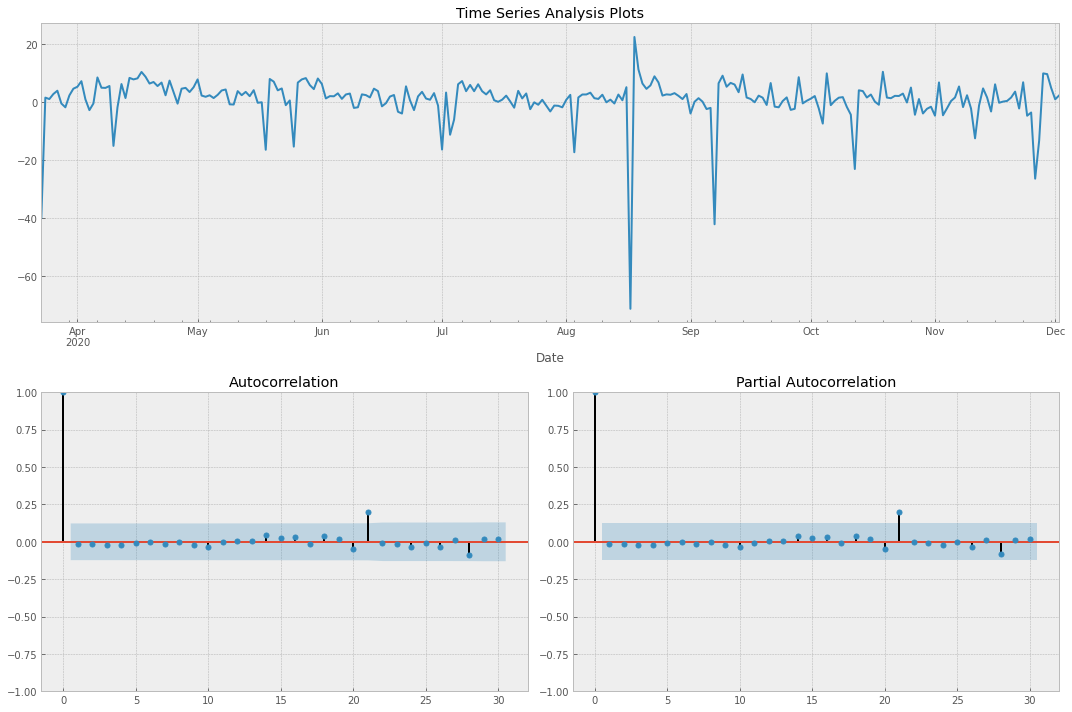

In [ ]:
tsplot(best_model.resid[7:], lags=30)

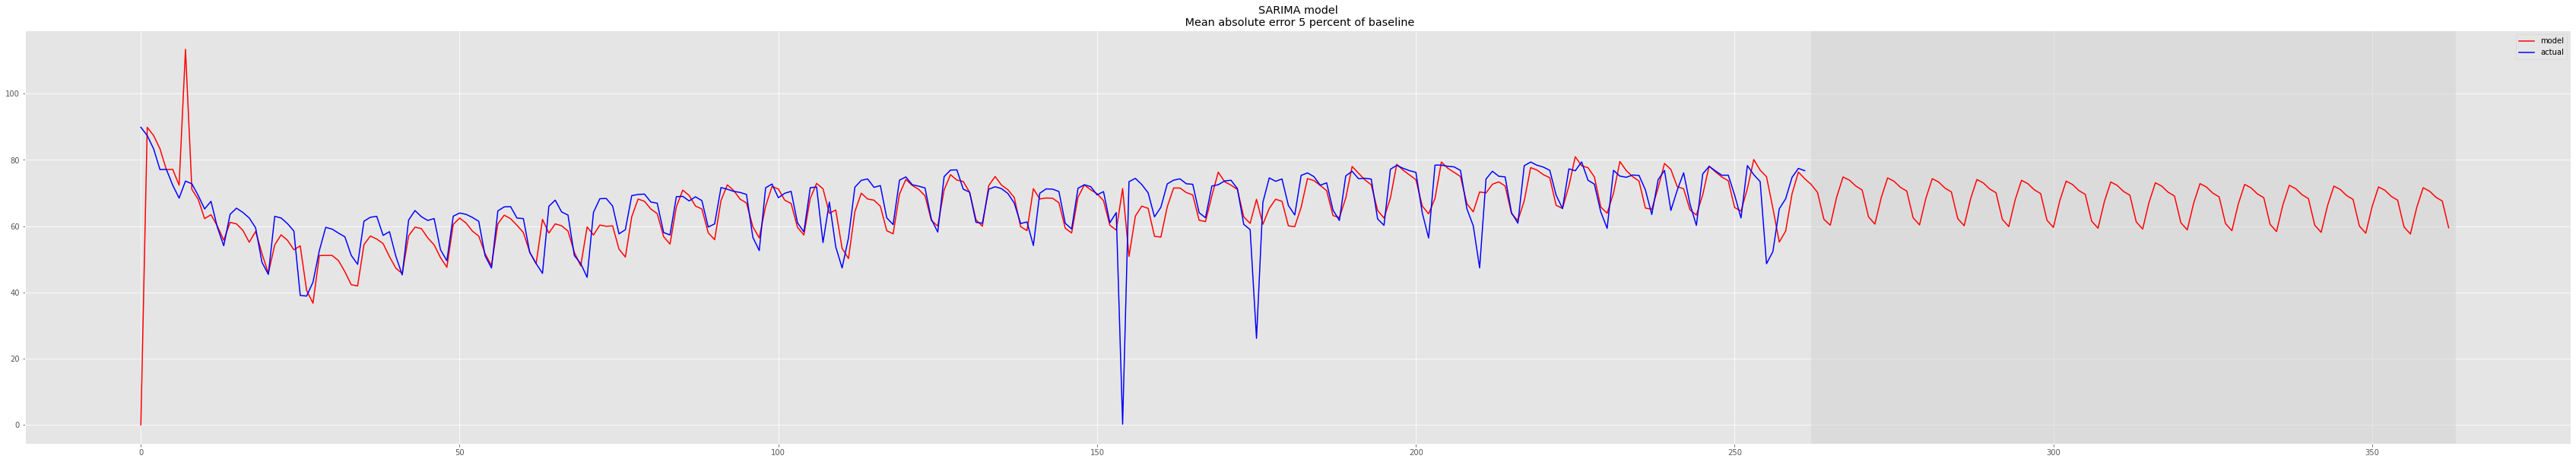

In [ ]:
df_timeline["arima_model"] = best_model.fittedvalues
forecast = best_model.predict(start = df_timeline.shape[0], end = df_timeline.shape[0]+100)
forecast = df_timeline.arima_model.append(forecast).values
actual = df_timeline.PercentOfBaseline.values
plt.figure(figsize=(60,10))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} percent of baseline".format(round(mean_absolute_error(df_timeline.dropna().PercentOfBaseline,  df_timeline.dropna().arima_model))))
plt.plot(actual, color='b', label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

**Видим, что модель достаточно неплохо описывает данные, ошибаясь на 5 percent of baseline по MAE**

#**Извлечение признаков (Feature extraction)**

In [ ]:
df_timeline.index = pd.to_datetime(df_timeline.index)
df_timeline["weekday"] = df_timeline.index.weekday
df_timeline['is_weekend'] = df_timeline.weekday.isin([5,6])*1
df_timeline

,Version,PercentOfBaseline,arima_model,weekday,is_weekend
Date,,,,,
2020-03-16,1.0,89.857143,0.000000,0,0
2020-03-17,1.0,87.357143,89.854147,1,0
2020-03-18,1.0,83.357143,87.357035,2,0
2020-03-19,1.0,77.071429,83.357300,3,0
2020-03-20,1.0,77.142857,77.071879,4,0
...,...,...,...,...,...
2020-11-28,1.0,65.214286,55.190592,5,1
2020-11-29,1.0,68.259259,58.482525,6,1
2020-11-30,1.0,74.714286,69.729829,0,0


**Сгруппируем и посмотрим на среднии по дням недели, а также для выходных и будних**

In [ ]:
df_timeline.groupby(['weekday']).agg({'PercentOfBaseline': 'mean'})

,PercentOfBaseline
weekday,
0,66.157275
1,72.075188
2,71.057331
3,69.136100
4,68.010010
5,59.943135
6,57.743856


In [ ]:
df_timeline.groupby(['is_weekend']).agg({'PercentOfBaseline': 'mean'})

,PercentOfBaseline
is_weekend,
0,69.294778
1,58.843496


**Видим, что различие среднего количества рейсов от нормального времени отличается для выходных и рабочих дней, возможно это связано с тем, что в выходные было выкуплено больше туристических поездок,которые могли быть отменены из-за ковидных ограничений**

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.PercentOfBaseline.shift(i)

    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    help_dict = dict(data[:test_index].groupby('weekday')['PercentOfBaseline'].mean())
    for key in help_dict:
      data['weekday'] = np.where((data.weekday == key), help_dict[key], data.weekday)

    # выкидываем закодированные средними признаки 
    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["PercentOfBaseline"], axis=1)
    y_train = data.loc[:test_index]["PercentOfBaseline"]
    X_test = data.loc[test_index:].drop(["PercentOfBaseline"], axis=1)
    y_test = data.loc[test_index:]["PercentOfBaseline"]

    return X_train, X_test, y_train, y_test

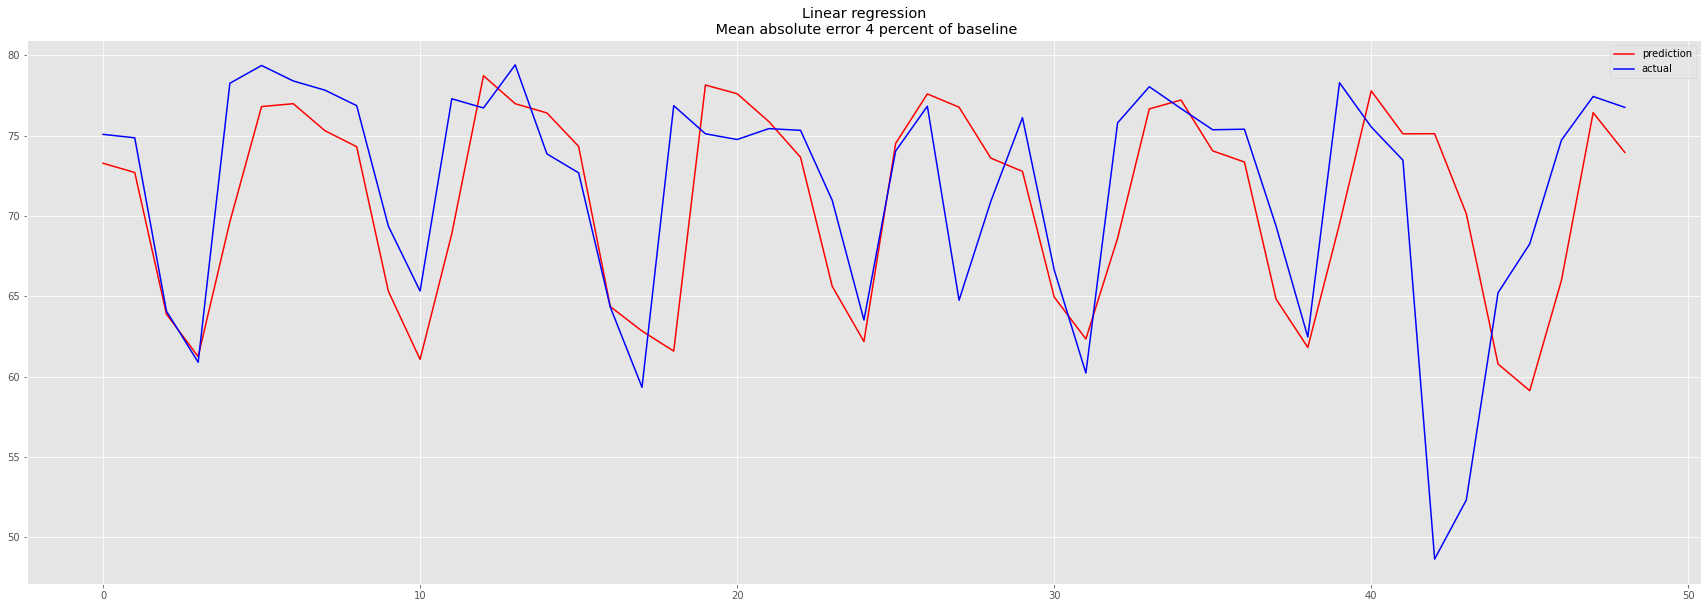

In [ ]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(df_timeline.PercentOfBaseline, test_size=0.3, lag_start=1, lag_end=31)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(30, 10))
plt.plot(prediction, color = "r", label="prediction")
plt.plot(y_test.values, color = "b", label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} percent of baseline".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

**Видим, что модель линейной регрессии на тестовых данных показывает ошибку меньше SARIMA и в целом неплохо описывает данные. Также стоит учитывать достаточно малое количество данных, 262 экземпляра, соответственно присутсвует малый размер обучающей выборки, что сказывается на результатах модели.**

**Проведем оценку модели на кросс-валидации**

In [ ]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [ ]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (158, 32)
Size of each fold: 31

Splitting the first 2 chunks at 1/2
Size of train + test: (62, 32)

Splitting the first 3 chunks at 2/3
Size of train + test: (93, 32)

Splitting the first 4 chunks at 3/4
Size of train + test: (124, 32)

Splitting the first 5 chunks at 4/5
Size of train + test: (155, 32)


6.406788880906852

**Видим, что на кросс валидации средняя ошибка в 6.5 percent of baseline, также как и в прошлом случае стоит учитывать малый размер выборки.**

# **XGBoost**

In [ ]:
def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data.PercentOfBaseline, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:squarederror',
        'booster':'gblinear',
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=5, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(30, 8))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(30, 8))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} percent of baseline".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

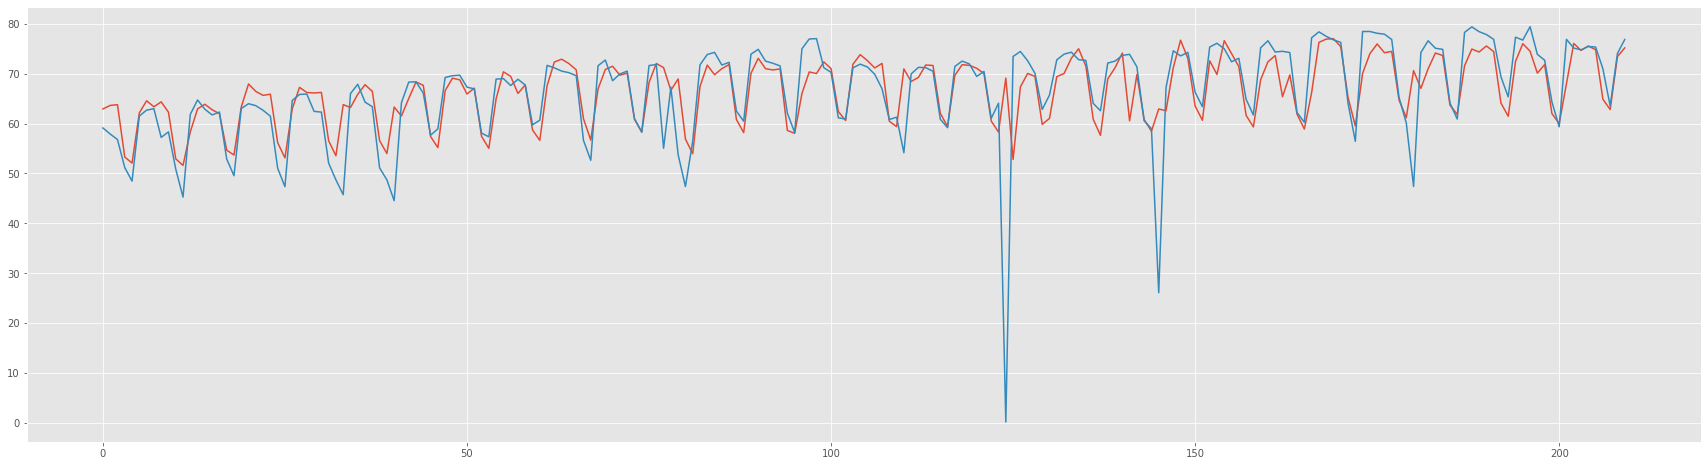

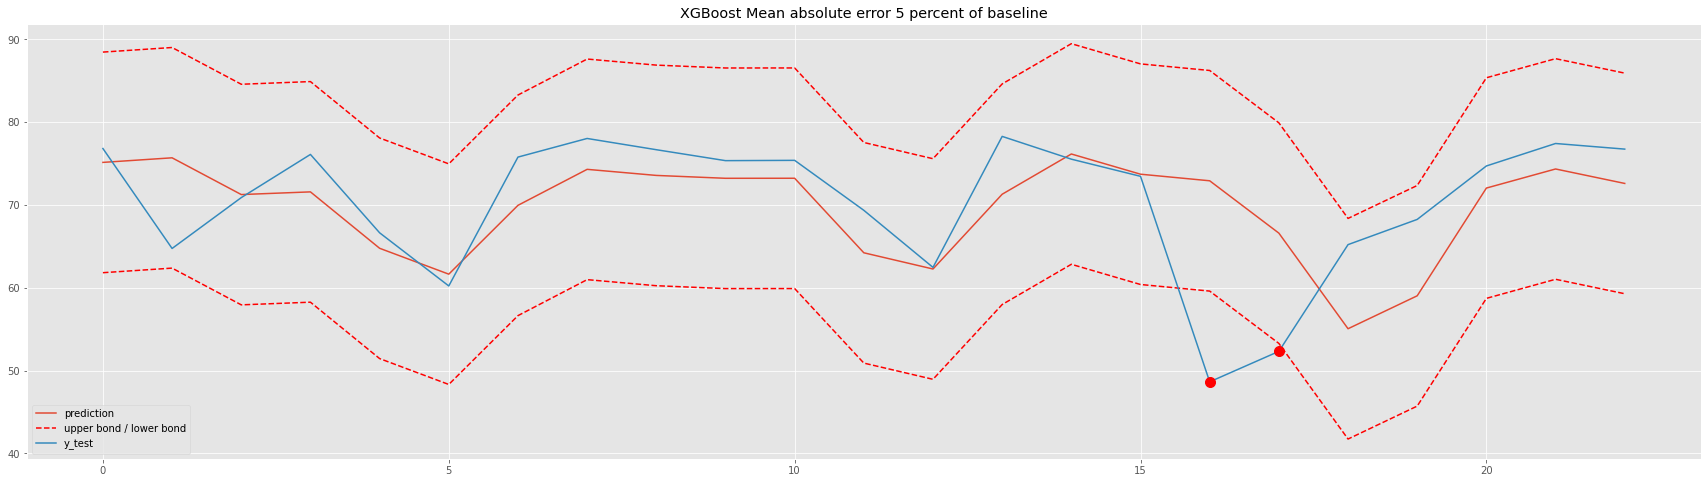

In [ ]:
XGB_forecast(df_timeline, test_size=0.2, lag_start=1, lag_end=31)

**Видим ошибку в 5 percent of baseline, пойманные аномалии на тестовом отрезке и достаточно неплохое описание поведения ряда, несмотря на малое количество экзмепляров в обучении.**